In [ ]:
# Uncomment if using colab and you need to grab traindata from drive

#"""
from google.colab import drive
drive.mount('/content/drive')
!rm -rf train test val
!mkdir traindata
!cp ./drive/MyDrive/strawberry.zip ./
!cp ./drive/MyDrive/cherry.zip ./
!cp ./drive/MyDrive/tomato.zip ./
!unzip ./strawberry.zip 
!unzip ./cherry.zip 
!unzip ./tomato.zip 
!mv ./strawberry ./traindata
!mv ./cherry ./traindata
!mv ./tomato ./traindata 
!python3 -m pip install split-folders
#"""

Mounted at /content/drive
Archive:  ./strawberry.zip
  inflating: strawberry/strawberry_1988.jpg  
  inflating: strawberry/strawberry_1999.jpg  
  inflating: strawberry/strawberry_1891.jpg  
  inflating: strawberry/strawberry_1677.jpg  
  inflating: strawberry/strawberry_2072.jpg  
  inflating: strawberry/strawberry_1763.jpg  
  inflating: strawberry/strawberry_2044.jpg  
  inflating: strawberry/strawberry_1751.jpg  
  inflating: strawberry/strawberry_2092.jpg  
  inflating: strawberry/strawberry_1739.jpg  
  inflating: strawberry/strawberry_1991.jpg  
  inflating: strawberry/strawberry_1860.jpg  
  inflating: strawberry/strawberry_1911.jpg  
  inflating: strawberry/strawberry_1827.jpg  
  inflating: strawberry/strawberry_1801.jpg  
  inflating: strawberry/strawberry_1814.jpg  
  inflating: strawberry/strawberry_1608.jpg  
  inflating: strawberry/strawberry_1651.jpg  
  inflating: strawberry/strawberry_2114.jpg  
  inflating: strawberry/strawberry_1869.jpg  
  inflating: strawberry/str

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F
import splitfolders
from PIL import Image
import numpy as np
import albumentations as A
import os
import splitfolders
from copy import copy
import matplotlib

In [ ]:
"""
Functions to perform data augmentation to increase 
training data size.
Also has function to 
split the input file into train,test,validation
and check for data leakage
"""

# Define augmentation pipeline
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.3),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.0625, 
            scale_limit=0.2, 
            rotate_limit=45, 
            p=0.2
        ),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.Affine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
])

def dupes_old(folds):
    """
    Just double checking if train test val have any overlapping files
    First method. Use collections
    """
    files=[]
    for folder in folds:
        files.append(os.listdir(folder))
    res = []
    for folder in files:
        for file in folder:
            res.append(file)
    #check if any files appear twice
    import collections
    print("duplicates: ",
        [item for item,count in collections.Counter(res).items() if count > 1]
    )

def dupes_new(fruit):
    """
    Just double checking if train test val have any overlapping files
    Second method, use sets
    """
    train_list = os.listdir(f'./train/{fruit}')
    test_list = os.listdir(f'./test/{fruit}')
    val_list = os.listdir(f'./val/{fruit}')
    print(
        f"train length {len(train_list)}",
        f"test length {len(test_list)}",
        f"val length {len(val_list)}"
    )

    # strip the "id" from our train, test, val images
    train_ids = []
    test_ids = []
    val_ids = []
    for name in train_list:
        train_ids.append(
            int(''.join(filter(str.isdigit, name)))
        )
    for name in test_list:
        test_ids.append(
            int(''.join(filter(str.isdigit, name)))
        )
    for name in val_list:
        val_ids.append(
            int(''.join(filter(str.isdigit, name)))
        )
    print("train file list sample: ", train_list[0:10])
    print("train ids list sample: ", train_ids[0:10])
    print("test file list sample: ", test_list[0:10])
    print("test ids list sample: ", test_ids[0:10])
    print("train file list sample: ", val_list[0:10])
    print("train ids list sample: ", val_ids[0:10])

    train_test_overlap = set(train_ids) & set(test_ids)
    train_val_overlap = set(train_ids) & set(val_ids)

    print("~"*30)
    print("Duplicates section")
    print("~"*30)
    print("Train test overlap: ", train_test_overlap)
    print("Train val overlap: ", train_val_overlap)

def data_aug(FROM,TO,num_augs=2):
    """
    Perform data augmentation on images files in
    FROM, the input folder and output the images in 
    TO, the output folder.
    in format {name}_aug.png
    """
    
    #items already in augmented dir
    target_dir = os.listdir(TO)
    source_dir = os.listdir(FROM)
    
    #enumerate over images
    for i,name in enumerate(source_dir):
        if 'aug' in name:
            #don't want to augment already augmented images
            print(f"passing {name}")
            pass
        else:
            print(f"augmenting {name}")
            try:
                #make several image augmentations on same image
                for i in range(num_augs):
                    image = Image.open(f'{FROM}/{name}')
                    image = np.asarray(image)
                    #transform image
                    transformed = transform(image=image)
                    image = transformed["image"]
                    image = Image.fromarray(image)
                    #save it if it doesn't already exist
                    #remove '.jpg' so we don't write it twice
                    name_prefix = name.split('.')[0]
                    name_dir = {0:'a',1:'b',2:'c'}
                    target_name = f'{name_prefix}_aug_{name_dir[i]}.jpg'
                    if target_name not in target_dir:
                        #avoid saving duplicates
                        print("Augmented: ", target_name, "Saving in: ", TO)
                        image.save(f'{TO}/{target_name}')
            except:
                print(f"Cannot open {name} as image")

In [ ]:
#split into train, val, test folders
splitfolders.ratio(
    "./traindata",
    output="./",
    seed=309,
    ratio=(0.8,0.1,0.1)
)

Copying files: 4044 files [00:00, 7213.19 files/s]


In [ ]:
#lets run data augmentation on all our fruits
#only run in 'train' folder, no point increasing test / val size

for input in ['train']:
    for fruit in ['cherry','strawberry','tomato']:
        print("~"*30)
        print(input,fruit)
        print("~"*30)
        data_aug(f'./{input}/{fruit}', f'./{input}/{fruit}')

Streaming output truncated to the last 5000 lines.
Augmented:  strawberry_0294_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_0294_aug_b.jpg Saving in:  ./train/strawberry
augmenting strawberry_1429.jpg
Augmented:  strawberry_1429_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_1429_aug_b.jpg Saving in:  ./train/strawberry
augmenting strawberry_1472.jpg
Augmented:  strawberry_1472_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_1472_aug_b.jpg Saving in:  ./train/strawberry
augmenting strawberry_1929.jpg
Augmented:  strawberry_1929_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_1929_aug_b.jpg Saving in:  ./train/strawberry
augmenting strawberry_0855.jpg
Augmented:  strawberry_0855_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_0855_aug_b.jpg Saving in:  ./train/strawberry
augmenting strawberry_0747.jpg
Augmented:  strawberry_0747_aug_a.jpg Saving in:  ./train/strawberry
Augmented:  strawberry_0747_aug_b.j

In [ ]:
"""
Check for duplicates in all these folders!
"""
folds = []
for folder in ['train','test','val']:
    for fruit in ['cherry','strawberry','tomato']:
        fold_name = f'./{folder}/{fruit}'
        folds.append(fold_name)
print(folds)

dupes_old(folds)

['./train/cherry', './train/strawberry', './train/tomato', './test/cherry', './test/strawberry', './test/tomato', './val/cherry', './val/strawberry', './val/tomato']
duplicates:  []


In [ ]:
"""
Double check just to be sure using a different method
"""

print("~"*30)
for fruit in ['cherry','strawberry','tomato']:
    print(f"Checking for duplicates in {fruit} folder")
    print("~"*30)
    dupes_new(fruit)
    print("~"*30)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Checking for duplicates in cherry folder
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
train length 3414 test length 143 val length 142
train file list sample:  ['cherry_0067.jpg', 'cherry_1558_aug_a.jpg', 'cherry_0619.jpg', 'cherry_0387_aug_b.jpg', 'cherry_0873_aug_a.jpg', 'cherry_1722_aug_a.jpg', 'cherry_0308_aug_a.jpg', 'cherry_1314_aug_b.jpg', 'cherry_1033_aug_b.jpg', 'cherry_0982.jpg']
train ids list sample:  [67, 1558, 619, 387, 873, 1722, 308, 1314, 1033, 982]
test file list sample:  ['cherry_2321.jpg', 'cherry_1718.jpg', 'cherry_1967.jpg', 'cherry_0457.jpg', 'cherry_0561.jpg', 'cherry_1347.jpg', 'cherry_0273.jpg', 'cherry_0216.jpg', 'cherry_1309.jpg', 'cherry_1016.jpg']
test ids list sample:  [2321, 1718, 1967, 457, 561, 1347, 273, 216, 1309, 1016]
train file list sample:  ['cherry_1150.jpg', 'cherry_0651.jpg', 'cherry_0782.jpg', 'cherry_0875.jpg', 'cherry_1759.jpg', 'cherry_1546.jpg', 'cherry_0667.jpg', 'cherry_1301.jpg', 'cherry_1711.jpg', 'cherry_1763.jpg']
t

In [ ]:
"""
Make dataloaders
resize imgs to be uniform size and 
pytorch tensor
"""
sz=300
process = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([sz,sz])
])

train_dataset = datasets.ImageFolder(root='train', transform=process)
train_loader = data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = datasets.ImageFolder(root='test', transform=process)
test_loader = data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

val_dataset = datasets.ImageFolder(root='val', transform=process)
val_loader = data.DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [ ]:
# Get gpu device for training if available otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# darknet conv function adapted from Darknet53 implementation
# https://github.com/developer0hye/PyTorch-Darknet53/blob/master/model.py

def dark_conv(c_in, c_out, kernel=1, stride=1, padding=0):
    """
    Construct a convolutional block function 
    given the input dimensions
    c_in: channels in
    c_out: channels out
    kernel: filter / convolution size (is square)
    stride: convolution stride 
    padding: convolution padding 

    Based on DarkNet19 configuration
    """
    return nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel, stride, padding),
            nn.BatchNorm2d(c_out),
            nn.Mish()
    )

# Our CNN model
class DarkNet19(nn.Module):
    def __init__(self):
        super(DarkNet19, self).__init__()
        self.c1 = dark_conv(3, 32, 3)
        self.c2 = dark_conv(32, 64, 3)
        self.c3 = dark_conv(64, 128, 3)
        self.c4 = dark_conv(128, 64, 1)
        self.c5 = dark_conv(64, 128, 3)
        self.c6 = dark_conv(128, 256, 3)
        self.c7 = dark_conv(256, 128, 1)
        self.c8 = dark_conv(128, 256, 3)
        self.c9 = dark_conv(256, 512, 3)
        self.c10 = dark_conv(512, 256, 1)
        self.c11 = dark_conv(256, 512, 3)
        self.c12 = dark_conv(512, 256, 1)
        self.c13 = dark_conv(256, 512, 3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512,3)

    def forward(self, x):
        # feature extraction
        x = self.c1(x)
        x = F.max_pool2d(x,2,2)
        x = self.c2(x)
        x = F.max_pool2d(x,2,2)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = F.max_pool2d(x,2,2)
        x = self.c6(x)
        x = self.c7(x)
        x = self.c8(x)
        x = F.max_pool2d(x,2,2)
        x = self.c9(x)
        x = self.c10(x)
        x = self.c11(x)
        x = self.c12(x)
        x = self.c13(x)
        # head
        x = self.global_avg_pool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        #softmax for pmf output
        output = F.softmax(x, dim=1)
        return output

#declare CNN model instance
model = DarkNet19().to(device)
print("Neural Network PyTorch Architecture:")
print(model)

#define loss function and optimizer
#cross entropy loss because we are doing binary classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

Using cuda device
Neural Network PyTorch Architecture:
DarkNet19(
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): M

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Function to train CNN model
    """
    size = len(dataloader.dataset)
    model.train()
    history = []
    total_correct = 0
    total_done = 0
    count = 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        preds = model(x)
        loss = loss_fn(preds, y)

        # Backpropagation block
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        # calculate accuracy 
        guesses = torch.argmax(preds, dim=1)
        correct = torch.sum(guesses==y).item()
        done = guesses.shape[0]
        total_correct += correct
        total_done += done

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        count += 1

    #average accuracy over training set during training
    acc = total_correct / total_done
    return acc, history
    
def test_acc(dataloader, model, loss_fn):
    """
    Compute loss and accuracy of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # we set model.eval() to turn off regularization stuff 
    # like dropout / batch norm
    model.eval()
    total_done = 0
    total_correct = 0
    test_loss = 0
    #don't store gradient when evaluating
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            # We compute this prediction loss
            loss = loss_fn(pred, y)
            guesses = torch.argmax(pred, dim=1)
            correct = torch.sum(guesses==y).item()
            done = guesses.shape[0]
            total_correct += correct
            total_done += done
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    acc = total_correct / total_done
    return acc, test_loss

Train and plot guesses

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
Interrupt when you see the validation accuracy plataeu 
We then load the best model weights (by validation accuracy)
and we can run inference with them
"""
#clear CUDA cache with garbage collector so we dont run out of memory
import gc
gc.collect()
torch.cuda.empty_cache()
#load best previous model
try:
    model = torch.load('best-model.pt')
except:
    print("No previous model.")

#train
best_val_acc = 0.0
epochs = 30
train_accs = []
train_losses = []
val_accs = []
val_losses = []
#initial val loss
val_acc, val_loss = test_acc(val_loader, model, loss_fn)
val_accs.append(val_acc)
val_losses.append(val_loss)
#initial training loss
train_acc, train_loss = test_acc(train_loader, model, loss_fn)
train_accs.append(train_acc)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, t_loss = train(train_loader, model, loss_fn, optimizer)
    train_accs.append(t_acc)
    train_losses.append(t_loss)
    v_acc, v_loss = test_acc(val_loader, model, loss_fn)
    # save best model
    if v_acc > best_val_acc:
        # Method 1
        torch.save(model, 'best-model.pt') 
        best_val_acc = v_acc
    print("~"*40)
    print(f"Current val acc: {v_acc:.3f} best: {best_val_acc:.3f}")
    print("~"*40)
    val_accs.append(v_acc)
    val_losses.append(v_loss)
print("Done!")

No previous model.
Epoch 1
-------------------------------
loss: 1.091847  [    0/ 9702]
loss: 0.899193  [ 3200/ 9702]
loss: 1.008143  [ 6400/ 9702]
loss: 0.865538  [ 9600/ 9702]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Current val acc: 0.725 best: 0.725
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2
-------------------------------
loss: 0.976567  [    0/ 9702]
loss: 0.824055  [ 3200/ 9702]
loss: 0.864433  [ 6400/ 9702]
loss: 0.763162  [ 9600/ 9702]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Current val acc: 0.673 best: 0.725
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3
-------------------------------
loss: 0.837091  [    0/ 9702]
loss: 0.831022  [ 3200/ 9702]
loss: 0.893857  [ 6400/ 9702]
loss: 0.878134  [ 9600/ 9702]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Current val acc: 0.804 best: 0.804
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4
-------------------------------
loss: 0.768704  [    0/ 9702]
loss: 0.807502  [ 3200/ 9702]


KeyboardInterrupt: ignored

In [ ]:
# save last model in case this works better than the "best one"
# (we may be overfitting to validation data by picking "best one" by val)
torch.save(model, 'last.pt')

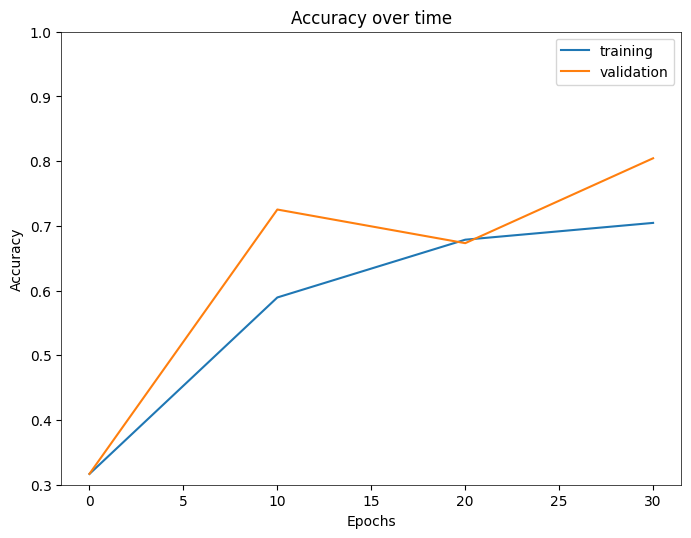

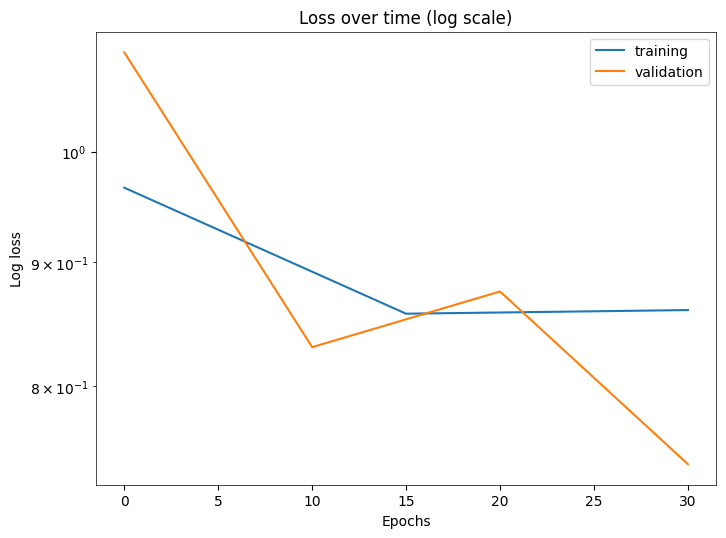

In [ ]:
# PLOT ACCURACIES
plt.rc('axes',edgecolor='black',linewidth=0.5)
train_accs = np.ravel(np.asarray(train_accs))
val_accs = np.reshape(val_accs,-1)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, num=len(train_accs))
x_v = np.linspace(0, epochs, num=len(val_accs))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, train_accs,label="training")
plt.plot(x_v, val_accs,label="validation")
plt.yscale("linear")
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('acc.png')
plt.ylim([0.3,1])
plt.show()

# PLOT LOSS
t_losses_final = np.ravel(np.mean(train_losses,axis=1))
#t_losses_final = np.ravel(train_losses)
val_losses_final = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_losses_final))
x_v = np.linspace(0, epochs, len(val_losses_final))
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_losses_final,label="training")
plt.plot(x_v, val_losses_final,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()

In [ ]:
"""
Given a build of the model, calculate test loss
"""
#first load best model
# Model class must be defined somewhere
model = torch.load('best-model.pt')
model.eval()
#test accuracy needs to be run with batch_size=1
test_accuracy = test_acc(test_loader, model, loss_fn)
print("Accuracy: ", test_accuracy[0])

Accuracy:  0.7906403940886699


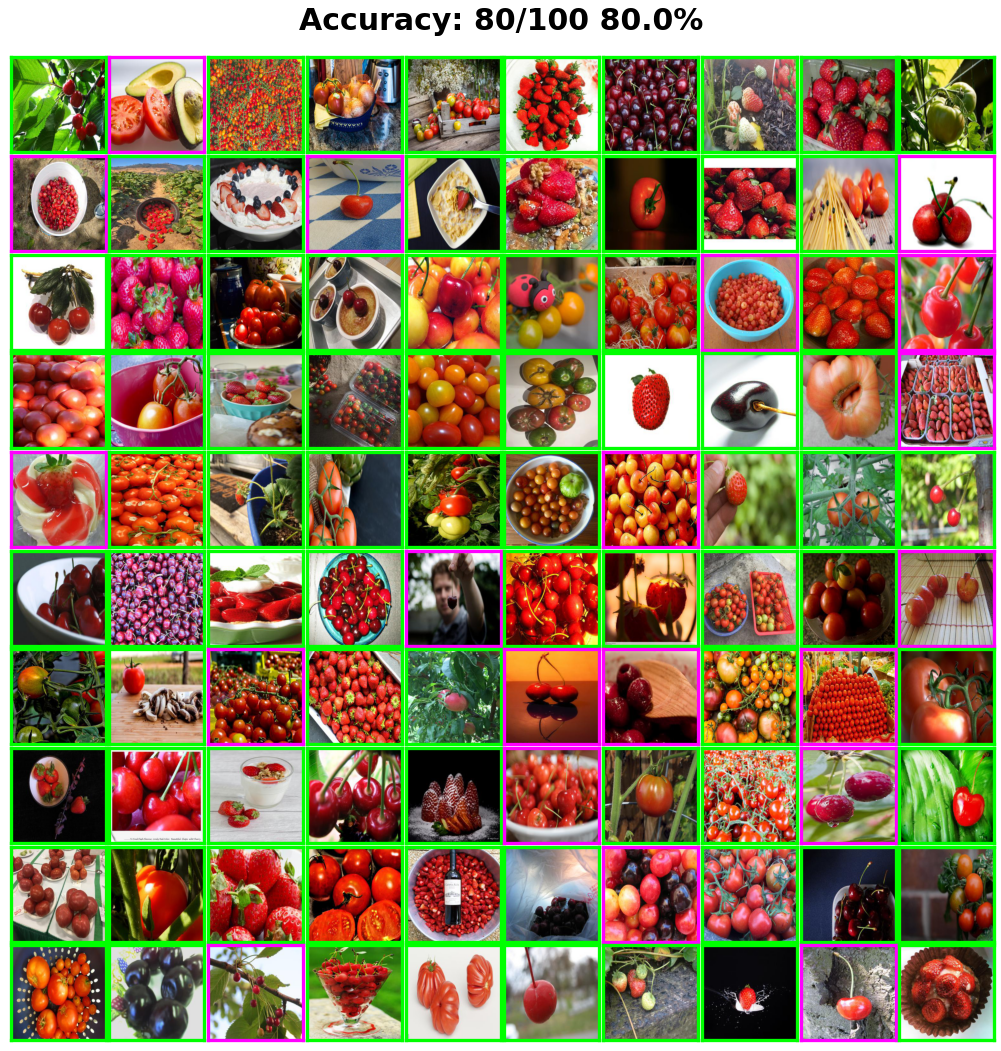

In [ ]:
"""
This section:
plot some guesses
on a grid. Correct guesses will 
be green.
"""

test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)
shapes = {"0":"C", "1":"S", "2":"T"}

plt.rc('axes',edgecolor='magenta',linewidth=3.3)

# size of guess grid (square) 
# min size 2x2
size=10

guesses = []
actual = []
#make grid for plotting
coords = []
for i in range(size):
    for j in range(size):
        coords.append([i,j])

fig, ax_arr = plt.subplots(size, size, figsize=(14, 14))

for batch, (x, y) in enumerate(test_loader):
    model.eval()
    pred_dist = model(x.to(device))
    #print("truth: ",truth)
    #print("pred dist: ",pred_dist)
    #grab the index of the maximum argument as our guess
    guess = str(torch.argmax(pred_dist).item())
    truth = f"{y[0].item()}"
    guesses.append(shapes[guess])
    actual.append(shapes[truth])
    grid_spot = coords[batch]
    ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
    ax_cur.imshow(torch.squeeze(x[0]).permute(1,2,0))
    ax_cur.set_xticks([])
    ax_cur.set_yticks([])
    if batch == (size*size-1):
        break

#set axis color to green if guess correct
for i in range(len(coords)):
    grid_spot = coords[i]
    ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
    guess = guesses[i]
    truth = actual[i]
    if guess==truth:
        for child in ax_cur.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('lime')

correct = len([val for i,val in enumerate(actual) if val==guesses[i]])
total = len(guesses)

#title for big or little samples
bigtitle=f"Accuracy: {correct}/{total} {100 * correct/total}%"
liltitle=f"Acc: {correct}/{total} {100 * correct/total}% \nReal: {actual} Guesses: {guesses}"

fig.suptitle(
    bigtitle,
    size=30,
    y=1.04,
    weight='bold'
)

plt.tight_layout()
plt.subplots_adjust(
    wspace=0.04, 
    hspace=0.04
)
plt.savefig(
    'guesses.png',
    bbox_inches='tight'
)

In [ ]:
#Uncomment if using Google Colab:
#Copy results to Google Drive for safekeeping

"""
!cp ./best-model.pt ./drive/MyDrive/AIML421_project/
!cp ./acc.png ./drive/MyDrive/AIML421_project/
!cp ./log_loss.png ./drive/MyDrive/AIML421_project/
!cp ./guesses.png ./drive/MyDrive/AIML421_project/
"""